In [34]:
'''
=====Experiment=====
Dataset: UNSW-NB15 dataset

Downsample 90% normal traffic randomly
Split train and test subgraph stratigically
Training in chronological window subgraph

IP + Port number as node
'''

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.loader import NeighborSampler
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# import seaborn as sns
# import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch_geometric.loader import DataLoader


project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Datasets.UNSW_NB15.UNSW_NB15_config import UNSW_NB15_Config

In [35]:
csv_file_name = "all_downsampled"

data = pd.read_csv(os.path.join(project_root, "Datasets", f"UNSW_NB15/All/{csv_file_name}.csv"))

DATASET_NAME = "UNSW_NB15"
EXPERIMENT_NAME = "strat_window_combined_port"

SOURCE_FILE_ID_COL_NAME = UNSW_NB15_Config.SOURCE_FILE_ID_COL_NAME

SOURCE_IP_COL_NAME = UNSW_NB15_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = UNSW_NB15_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = UNSW_NB15_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = UNSW_NB15_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = UNSW_NB15_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = UNSW_NB15_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = UNSW_NB15_Config.BENIGN_CLASS_NAME

TIME_COLS = UNSW_NB15_Config.TIME_COL_NAMES

print(data[ATTACK_CLASS_COL_NAME].value_counts())
print(data[IS_ATTACK_COL_NAME].value_counts())

MULTICLASS = True

if MULTICLASS:
    label_col = ATTACK_CLASS_COL_NAME
    data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
else:
    label_col = IS_ATTACK_COL_NAME
    data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)


saves_path = os.path.join(project_root, "Models/E_GraphSAGE/logs", DATASET_NAME, EXPERIMENT_NAME)

checkpoint_path = os.path.join(saves_path, f"checkpoints_{csv_file_name}.pth")
best_model_path = os.path.join(saves_path, f"best_model_{csv_file_name}.pth")

os.makedirs(saves_path, exist_ok=True)

attack_cat
Normal            221876
Generic           215481
Exploits           44525
Fuzzers            24246
DoS                16353
Reconnaissance     13987
Analysis            2677
Backdoors           2329
Shellcode           1511
Worms                174
Name: count, dtype: int64
label
1    321283
0    221876
Name: count, dtype: int64


In [36]:
data.drop(columns=UNSW_NB15_Config.DROP_COLS,inplace=True)
print(data.columns)

Index(['srcip', 'sport', 'dstip', 'dsport', 'state', 'dur', 'sbytes', 'dbytes',
       'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts',
       'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
       'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt',
       'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl',
       'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'source_file_id'],
      dtype='object')


In [37]:
data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

# # Combine Port and IP
data[SOURCE_PORT_COL_NAME] = data[SOURCE_PORT_COL_NAME].apply(str)
data[DESTINATION_PORT_COL_NAME] = data[DESTINATION_PORT_COL_NAME].apply(str)

data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME] + ':' + data[SOURCE_PORT_COL_NAME]
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME] + ':' + data[DESTINATION_PORT_COL_NAME]
data.drop(columns=[SOURCE_PORT_COL_NAME,DESTINATION_PORT_COL_NAME],inplace=True)

data = pd.get_dummies(data, columns = UNSW_NB15_Config.CATEGORICAL_COLS) # One Hot Encoding for categorical data
converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(UNSW_NB15_Config.CATEGORICAL_COLS))]

In [38]:
print(data.head)

<bound method NDFrame.head of                      srcip                dstip        dur  sbytes  dbytes  \
0             10.40.85.1:0          224.0.0.5:0  50.004341     384       0   
1          59.166.0.6:2142     149.171.126.4:53   0.001134     132     164   
2       175.45.176.0:13284    149.171.126.16:80   2.390390    1362     268   
3         59.166.0.3:42587     149.171.126.8:25  34.077175   37358    3380   
4            10.40.170.2:0        10.40.170.2:0   0.000000      46       0   
...                    ...                  ...        ...     ...     ...   
543154  175.45.176.1:17386  149.171.126.11:6071   0.291164     732     468   
543155  175.45.176.3:36130  149.171.126.16:2140   0.011751      76     132   
543156    59.166.0.2:27607     149.171.126.4:53   0.002410     146     178   
543157  175.45.176.1:24448  149.171.126.11:5250   0.176514   10778     268   
543158    59.166.0.2:10376   149.171.126.2:8406   0.049598    2646   25564   

        sttl  dttl  sloss  dloss 

In [39]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)
data.fillna(0,inplace = True)
data.drop(columns=['index'],inplace=True)
print(data.head)

<bound method NDFrame.head of                      srcip                dstip        dur  sbytes  dbytes  \
0             10.40.85.1:0          224.0.0.5:0  50.004341     384       0   
1          59.166.0.6:2142     149.171.126.4:53   0.001134     132     164   
2       175.45.176.0:13284    149.171.126.16:80   2.390390    1362     268   
3         59.166.0.3:42587     149.171.126.8:25  34.077175   37358    3380   
4            10.40.170.2:0        10.40.170.2:0   0.000000      46       0   
...                    ...                  ...        ...     ...     ...   
543154  175.45.176.1:17386  149.171.126.11:6071   0.291164     732     468   
543155  175.45.176.3:36130  149.171.126.16:2140   0.011751      76     132   
543156    59.166.0.2:27607     149.171.126.4:53   0.002410     146     178   
543157  175.45.176.1:24448  149.171.126.11:5250   0.176514   10778     268   
543158    59.166.0.2:10376   149.171.126.2:8406   0.049598    2646   25564   

        sttl  dttl  sloss  dloss 

In [40]:
scaler = StandardScaler()
cols_to_norm = UNSW_NB15_Config.COLS_TO_NORM
print(data[cols_to_norm].describe()) # Check if there's any too large value

                 dur        sbytes        dbytes           sttl  \
count  543159.000000  5.431590e+05  5.431590e+05  543159.000000   
mean        0.703562  5.129376e+03  1.912066e+04     157.223966   
std        12.635598  1.202304e+05  1.382834e+05     108.429349   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
25%         0.000007  1.140000e+02  0.000000e+00      31.000000   
50%         0.000010  2.000000e+02  0.000000e+00     254.000000   
75%         0.070875  1.580000e+03  1.936000e+03     254.000000   
max      8760.776367  1.435577e+07  1.465753e+07     255.000000   

                dttl          sloss          dloss         Sload  \
count  543159.000000  543159.000000  543159.000000  5.431590e+05   
mean       38.847354       3.789714       8.637535  6.901181e+07   
std        77.059190      45.614073      49.869719  1.425974e+08   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%         0.000000       0.000000       0.000000  3.76

In [41]:
def check_numeric_issues(df, cols_to_norm):
    for col in cols_to_norm:
        try:
            # Try to coerce to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Try to clip the column
            df[col] = df[col].clip(lower=-1e9, upper=1e9)
            
        except Exception as e:
            print(f"❌ Column '{col}' failed with error: {e}")
            print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
            print(f"  - Data type: {df[col].dtype}")
            continue

    print("\n✅ All other columns processed successfully.")

check_numeric_issues(data, UNSW_NB15_Config.COLS_TO_NORM)


✅ All other columns processed successfully.


In [42]:
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [43]:
from sklearn.preprocessing import LabelEncoder

num_classes = 2
class_map = [0, 1]
if MULTICLASS:
    le = LabelEncoder()
    attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
    class_map = le.classes_
    print(class_map)
    print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
    data[ATTACK_CLASS_COL_NAME] = attack_labels
    num_classes = len(class_map)
    class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
ADVERSARIAL_CLASS_LABEL = len(class_map)

['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
Attack label mapping: {'Analysis': 0, 'Backdoors': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4, 'Generic': 5, 'Normal': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}


In [44]:
# # Maintain the order of the rows in the original dataframe

feature_cols = cols_to_norm + converted_categorical_cols

print('Feature Columns:', feature_cols)
num_features = len(feature_cols)
print('Number of Features:', num_features)

data['h'] = data[ feature_cols ].values.tolist()

Feature Columns: ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'state_ACC', 'state_CLO', 'state_CON', 'state_ECO', 'state_ECR', 'state_FIN', 'state_INT', 'state_MAS', 'state_PAR', 'state_REQ', 'state_RST', 'state_TST', 'state_TXD', 'state_URH']
Number of Features: 52


In [45]:
def create_graph(df):

    G_nx = nx.from_pandas_edgelist(df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    return G_pyg

In [46]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

class StratifiedGraphDataset:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        self.class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )

    def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
        cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

        mlb = MultiLabelBinarizer()

        y_binary = mlb.fit_transform(self.y)

        return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        train_idx, test_idx = next(self.k_fold_split(k = 1, test_ratio = test_ratio, random_state = random_state))
        
        X_train = [self.X[i] for i in train_idx]
        X_test = [self.X[i] for i in test_idx]

        y_train = [self.y[i] for i in train_idx]
        y_test = [self.y[i] for i in test_idx]

        return StratifiedGraphDataset(X_train, y_train), StratifiedGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            count = class_counts_named[cls_label]
            weight = class_weights_named[cls_label]
            print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
    
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g
            
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.X[idx], self.y[idx]
        elif isinstance(idx, slice):
            return [self.X[i] for i in range(len(self.X))][idx], [self.y[i] for i in range(len(self.y))][idx]
        else:
            raise TypeError("Index must be an integer or a slice.")

def generate_graph_datasets(
    df: pd.DataFrame, 
    window_size: int = 200, 
    # overlap_ratio: float = 0, 
    feature_cols=feature_cols,
    ordering_cols= TIME_COLS, 
    label_col=label_col,
    build_graph_func=create_graph,
    # downsampler=downsampler
    ):

    print("All Columns: ", df.columns)
    print("Ordering Columns: ", ordering_cols)
    assert all(col in df.columns for col in ordering_cols), "All timestamp columns are required"
    assert label_col in df.columns, "Edge label column 'label' is required"
    
    df = df.sort_values(ordering_cols).reset_index(drop=True)
    window_size = int(window_size)
    
    df.drop(columns=set(df.columns) - set(feature_cols) - set(label_col))

    print("Final Columns: ", df.columns)
    
    label_counts_list = []
    X = []
    y = []

    progress_bar = tqdm(range(0, len(df), window_size), desc=f"Generating graphs")
    for start in progress_bar:
        window_df = df[start: min(start + window_size, len(df))]
        contains_label = window_df[label_col].unique()

        G_pyg = build_graph_func(window_df)

        label_counts = window_df[label_col].value_counts()

        label_counts_list.append(label_counts)
        X.append(G_pyg)
        y.append(contains_label.tolist())

    # X, y = downsampler.downsample(label_counts_list, X, y)
        
    return StratifiedGraphDataset(X, y)

In [47]:
graph_dataset = generate_graph_datasets(data)
full_train_graph_dataset, test_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)


All Columns:  Index(['srcip', 'dstip', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss',
       'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb',
       'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit',
       'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
       'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm',
       'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'attack_cat', 'source_file_id', 'state_ACC', 'state_CLO', 'state_CON',
       'state_ECO', 'state_ECR', 'state_FIN', 'state_INT', 'state_MAS',
       'state_PAR', 'state_REQ', 'state_RST', 'state_TST', 'state_TXD',
       'state_URH', 'h'],
      dtype='object')
Ordering Columns:  ['Stime', 'Ltime']
Final Columns:  Index(['srcip', 'dstip', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss',
       'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts'

Generating graphs: 100%|██████████| 2716/2716 [00:22<00:00, 121.33it/s]


In [48]:
print("Class Distrubution:", data[label_col].value_counts())

print("Number of graphs after downsampling:", len(graph_dataset))
graph_dataset.print_class_distribution_and_weights()
print("Number of training graphs:", len(full_train_graph_dataset))
full_train_graph_dataset.print_class_distribution_and_weights()
print("Number of testing graphs:", len(test_graph_dataset))
test_graph_dataset.print_class_distribution_and_weights()

Class Distrubution: attack_cat
6    221876
5    215481
3     44525
4     24246
2     16353
7     13987
0      2677
1      2329
8      1511
9       174
Name: count, dtype: int64
Number of graphs after downsampling: 2716
Class Counts and Weights:
6   Normal         : Count = 221876    , Weight = 0.2448    
7   Reconnaissance : Count = 13987     , Weight = 3.8833    
3   Exploits       : Count = 44525     , Weight = 1.2199    
2   DoS            : Count = 16353     , Weight = 3.3215    
5   Generic        : Count = 215481    , Weight = 0.2521    
8   Shellcode      : Count = 1511      , Weight = 35.9470   
4   Fuzzers        : Count = 24246     , Weight = 2.2402    
9   Worms          : Count = 174       , Weight = 312.1603  
1   Backdoors      : Count = 2329      , Weight = 23.3216   
0   Analysis       : Count = 2677      , Weight = 20.2898   
Number of training graphs: 2308
Class Counts and Weights:
6   Normal         : Count = 189357    , Weight = 0.2438    
7   Reconnaissance : Count

In [49]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [50]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [51]:
th.cuda.empty_cache()

In [52]:


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)



In [53]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def grid_search(graph_dataset, epochs, learning_rates, hidden_dims, folds=3):
    global num_features
    
    best_params = {}
    best_f1 = 0

    # Precompute the train and validation graphs for all folds
    folds_list = []
    for i in range(folds):
        train_graph_dataset, val_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=i)
        folds_list.append((train_graph_dataset, val_graph_dataset))

    params_results = {}
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for drop_out in drop_outs:
                print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}")
                fold_f1_scores = []

                for fold, (train_graph_dataset, val_graph_dataset) in enumerate(folds_list):
                    print(f"Fold {fold + 1}")

                    model = EGraphSAGE(node_in_channels=num_features,
                                    edge_in_channels=num_features,
                                    hidden_channels=hidden_dim,
                                    dropout = drop_out,
                                    out_channels=num_classes).to(device)

                    model.apply(init_weights)

                    # Normalize to stabilize training
                    class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
                    print("Class weights:", class_weights)

                    criterion = nn.CrossEntropyLoss(weight=class_weights)
                    optimizer = th.optim.Adam(model.parameters(), lr=lr)
                    scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

                    best_epoch_f1 = 0  # Track the best F1 score for this fold

                    for epoch in range(epochs):
                        try:
                            total_train_loss = 0
                            total_val_loss = 0

                            model.train()
                            for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):
                                G_pyg_train = G_pyg_train.to(device)

                                G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                                G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)
                                
                                out = model(G_pyg_train)
                                loss = criterion(out, G_pyg_train.edge_label)
                                total_train_loss += loss.item()

                                optimizer.zero_grad()
                                loss.backward()

                                optimizer.step()
                                scheduler.step()
                            
                            model.eval()

                            test_label_list = []
                            pred_label_list = []

                            with th.no_grad():
                                for G_pyg_val in tqdm(val_graph_dataset, desc="Validation", leave=False):

                                    G_pyg_val.to(device)
                                    G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                                    G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                                    out = model(G_pyg_val)
                                    loss = criterion(out, G_pyg_val.edge_label)
                                    total_val_loss += loss.item()

                            test_label = th.cat(test_label_list)
                            pred_label = th.cat(pred_label_list)

                            val_f1 = f1_score(test_label.cpu(), pred_label.cpu(), average='weighted')

                            if val_f1 > best_epoch_f1:
                                best_epoch_f1 = val_f1  # Update the best F1 score for this fold
                                print(f"Best F1 Score at epoch {epoch}: {best_epoch_f1:.4f}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Parameters: lr={lr}, hidden_dim={hidden_dim}, drop_out={drop_out}")

                            print(f'Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Validation F1: {avg_f1:.4f}')

                        except Exception as e:
                            print(f"An error occurred at epoch {epoch}: {str(e)}")
                            break

                    fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                
                avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                print(f"Average F1 Score for drop_out {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

    print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
    print("All results:", params_results)


learning_rates = [0.001, 0.005, 0.01, 0.05]
hidden_dims = [128, 256, 512]
drop_outs = [0.2, 0.3, 0.4]

# grid_search(full_train_graph_dataset, epochs=10, learning_rates=learning_rates, hidden_dims=hidden_dims, drop_outs=drop_outs)


In [54]:
train_graph_dataset, val_graph_dataset = full_train_graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)

In [55]:
import pickle

def save_progress(epoch, model, optimizer, scheduler, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs):
    global checkpoint_path, train_loss_history_path, val_loss_history_path, val_f1_history_path, saved_model_epochs_path

    # Save checkpoint
    th.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_f1': best_f1
    }, checkpoint_path)
    with open(train_loss_history_path, 'wb') as f:
        pickle.dump(train_loss_history, f)
    with open(val_loss_history_path, 'wb') as f:
        pickle.dump(val_loss_history, f)
    with open(val_f1_history_path, 'wb') as f:
        pickle.dump(val_f1_history, f)
    with open(saved_model_epochs_path, 'wb') as f:
        pickle.dump(saved_model_epochs, f)

In [56]:
# Extract the best parameters from the grid search
import pickle


best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.01  # Replace with the best learning_rate found
best_drop_out = 0.3  # Replace with the best drop_out found
epochs = 200

print("Number of train graphs: ", len(train_graph_dataset))

# Initialize the model with the best parameters
model = EGraphSAGE(node_in_channels=num_features, 
                   edge_in_channels=num_features,
                   hidden_channels=best_hidden_dim,
                   dropout = best_drop_out,
                   out_channels=num_classes).to(device)

model.apply(init_weights)

# Normalize class weights
class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
print("Class weights:", class_weights)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# ===== Load checkpoint if exists =====
best_f1 = 0
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    print(f"Resumed training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []
val_f1_history = []
saved_model_epochs = []

train_loss_history_path = os.path.join(saves_path, 'train_loss_history.pkl')
val_loss_history_path = os.path.join(saves_path, 'val_loss_history.pkl')
val_f1_history_path = os.path.join(saves_path, 'val_f1_history.pkl')
saved_model_epochs_path = os.path.join(saves_path, 'saved_model_epochs.pkl')

if os.path.exists(train_loss_history_path) and os.path.exists(val_loss_history_path) and os.path.exists(val_f1_history_path) and os.path.exists(saved_model_epochs_path):
    with open(train_loss_history_path, 'rb') as f:
        train_loss_history = pickle.load(f)
    with open(val_loss_history_path, 'rb') as f:
        val_loss_history = pickle.load(f)
    with open(val_f1_history_path, 'rb') as f:
        val_f1_history = pickle.load(f)
    with open(saved_model_epochs_path, 'rb') as f:
        saved_model_epochs = pickle.load(f)

# ===== Start Training =====
for epoch in range(start_epoch, epochs):
    model.train()

    train_loss = 0
    num_train_graphs = len(train_graph_dataset)

    val_loss = 0
    num_val_graphs = len(val_graph_dataset)

    optimizer.zero_grad()
    for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

        # Move the graph data to the device
        G_pyg_train = G_pyg_train.to(device)
        G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
        G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

        out = model(G_pyg_train)
        loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
        
        train_loss += loss.item()
        loss.backward()

    optimizer.step()
    scheduler.step()

    test_label_list = []
    pred_label_list = []

    model.eval()
    with th.no_grad():
        for G_pyg_val in tqdm(val_graph_dataset, desc="Evaluation", leave=False):
            G_pyg_val = G_pyg_val.to(device)
            G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
            G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

            out = model(G_pyg_val)
            loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
            val_loss += loss.item()

            test_label_list.append(G_pyg_val.edge_label.cpu())
            pred_label_list.append(out.argmax(dim=1).cpu())

    test_label = th.cat(test_label_list)
    pred_label = th.cat(pred_label_list)

    val_f1 = f1_score(test_label, pred_label, average='weighted')
    val_f1_micro = f1_score(test_label, pred_label, average='micro')
    val_f1_macro = f1_score(test_label, pred_label, average='macro')
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

    if val_f1 > best_f1:
        best_f1 = val_f1  # Update the best F1 score for this fold
        best_model_state = model.state_dict()
        saved_model_epochs.append(epoch)

        save_progress(epoch, model, optimizer, scheduler, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)
        th.save(best_model_state, best_model_path)
        print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

    if epoch % 10 == 0:
        # Save checkpoint
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')
        save_progress(epoch, model, optimizer, scheduler, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

# Save the trained model
end_epoch = epochs
save_progress(end_epoch, model, optimizer, scheduler, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)
print("Model training completed and saved.")

Number of train graphs:  1961
Class weights: tensor([2.0300e+01, 2.3698e+01, 3.2526e+00, 1.2178e+00, 2.2489e+00, 2.5452e-01,
        2.4317e-01, 3.8033e+00, 3.6081e+01, 3.1127e+02], device='cuda:0')


Training:   0%|          | 0/1961 [00:00<?, ?it/s]

Epoch 0 Saved best model. Best F1: 0.25824800367084616
Epoch 0, Train Loss: 2.5919, Validation Loss: 7.9592, Validation F1: 0.2582


Epoch 1 Saved best model. Best F1: 0.29170326017424403


Epoch 2 Saved best model. Best F1: 0.40185805929068413


Epoch 3 Saved best model. Best F1: 0.7640070041300394


Epoch 5 Saved best model. Best F1: 0.7652579171120649


Epoch 7 Saved best model. Best F1: 0.7902484228374077


Epoch 8 Saved best model. Best F1: 0.8040956899821886


Epoch 9 Saved best model. Best F1: 0.8117933957703527


Epoch 10 Saved best model. Best F1: 0.8322222968283886
Epoch 10, Train Loss: 1.2165, Validation Loss: 1.1800, Validation F1: 0.8322


Epoch 11 Saved best model. Best F1: 0.8393473019870288


Epoch 12 Saved best model. Best F1: 0.852000220503839


Epoch 13 Saved best model. Best F1: 0.8676736249675736


Epoch 16 Saved best model. Best F1: 0.872638598462447


Epoch 17 Saved best model. Best F1: 0.8750070186565453


Epoch 18 Saved best model. Best F1: 0.8751473874223885


Epoch 19 Saved best model. Best F1: 0.8796172299547003


Epoch 20 Saved best model. Best F1: 0.8811546280542214
Epoch 20, Train Loss: 0.9244, Validation Loss: 0.8777, Validation F1: 0.8812


Epoch 24 Saved best model. Best F1: 0.8870911121866356


Epoch 25 Saved best model. Best F1: 0.8918414103694822


Epoch 26 Saved best model. Best F1: 0.8920788552260608


Epoch 30, Train Loss: 0.8383, Validation Loss: 0.8057, Validation F1: 0.8871


Epoch 33 Saved best model. Best F1: 0.8924953853406579


Epoch 34 Saved best model. Best F1: 0.8964043038847767


Epoch 38 Saved best model. Best F1: 0.8975699742439869


Epoch 39 Saved best model. Best F1: 0.8979185736671118


Epoch 40, Train Loss: 0.7779, Validation Loss: 0.7626, Validation F1: 0.8969


Epoch 46 Saved best model. Best F1: 0.9008843869491636


Epoch 50, Train Loss: 0.7304, Validation Loss: 0.7289, Validation F1: 0.8994


Epoch 59 Saved best model. Best F1: 0.9015597847300652


Epoch 60, Train Loss: 0.7034, Validation Loss: 0.7247, Validation F1: 0.8982


Epoch 70, Train Loss: 0.6809, Validation Loss: 0.7061, Validation F1: 0.9002


Epoch 72 Saved best model. Best F1: 0.9024499078486219


Epoch 80, Train Loss: 0.6625, Validation Loss: 0.6915, Validation F1: 0.8997


Epoch 90, Train Loss: 0.6484, Validation Loss: 0.6812, Validation F1: 0.8969


Epoch 100, Train Loss: 0.6380, Validation Loss: 0.6697, Validation F1: 0.8978


Epoch 103 Saved best model. Best F1: 0.9028073703035054


Epoch 109 Saved best model. Best F1: 0.9031463502031144


Epoch 110, Train Loss: 0.6210, Validation Loss: 0.6631, Validation F1: 0.9021


Epoch 120, Train Loss: 0.6119, Validation Loss: 0.6499, Validation F1: 0.9017


Epoch 130, Train Loss: 0.6027, Validation Loss: 0.6451, Validation F1: 0.9024


Epoch 133 Saved best model. Best F1: 0.9032629710779347


Epoch 140, Train Loss: 0.5956, Validation Loss: 0.6409, Validation F1: 0.9021


Epoch 141 Saved best model. Best F1: 0.903372120121651


Epoch 143 Saved best model. Best F1: 0.9036561792108627


Epoch 144 Saved best model. Best F1: 0.9041937758219868


Epoch 150, Train Loss: 0.5907, Validation Loss: 0.6357, Validation F1: 0.9029


Epoch 153 Saved best model. Best F1: 0.9043365306657676


Epoch 160, Train Loss: 0.5877, Validation Loss: 0.6330, Validation F1: 0.9041


Epoch 162 Saved best model. Best F1: 0.9044310111980639


Epoch 170 Saved best model. Best F1: 0.9046921061745317
Epoch 170, Train Loss: 0.5859, Validation Loss: 0.6319, Validation F1: 0.9047


Epoch 176 Saved best model. Best F1: 0.9050403781357895


Epoch 180 Saved best model. Best F1: 0.9050500190234614
Epoch 180, Train Loss: 0.5826, Validation Loss: 0.6311, Validation F1: 0.9051


Epoch 182 Saved best model. Best F1: 0.9052121285496368


Epoch 183 Saved best model. Best F1: 0.9052231034339544


Epoch 184 Saved best model. Best F1: 0.9053074250952202


Epoch 190, Train Loss: 0.5840, Validation Loss: 0.6305, Validation F1: 0.9051


Model training completed and saved.


In [57]:
def plot_training_process(train_losses, val_losses, val_f1, saved_model_epochs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_losses, label='Train Loss', color='blue')
    axs[0].plot(val_losses, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_losses))

    plt.tight_layout()
    plt.show()

200


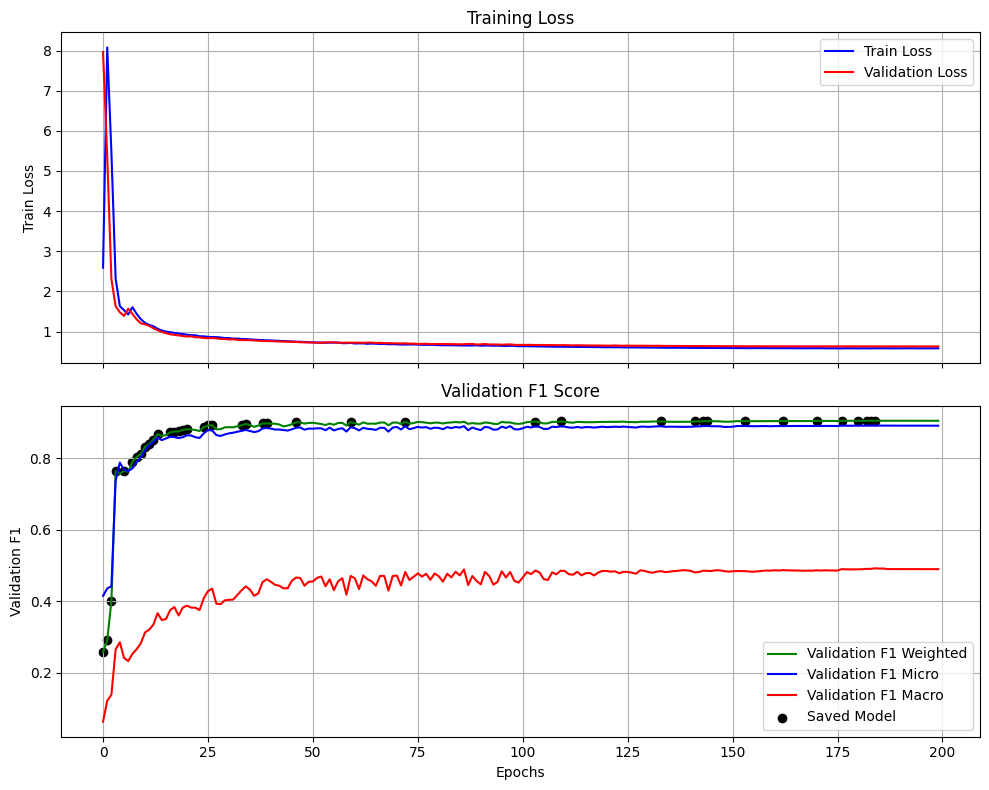

In [58]:
plot_training_process(train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

In [59]:
import torch
from torch_geometric.utils import degree
from collections import defaultdict

def check_global_avg_degrees_per_class(graph_dataset):
    # Dictionaries to hold total degree sums and counts per class
    total_out_deg = defaultdict(float)
    total_in_deg = defaultdict(float)
    count_out_nodes = defaultdict(int)
    count_in_nodes = defaultdict(int)
    min_out_deg = defaultdict(lambda: float('inf'))
    max_out_deg = defaultdict(lambda: float('-inf'))
    min_in_deg = defaultdict(lambda: float('inf'))
    max_in_deg = defaultdict(lambda: float('-inf'))

    for graph in graph_dataset:
        edge_index = graph.edge_index
        edge_label = graph.edge_label
        num_nodes = graph.num_nodes

        unique_classes = torch.unique(edge_label)

        for cls in unique_classes:
            cls = int(cls)
            mask = (edge_label == cls)

            src_nodes = edge_index[0][mask]
            dst_nodes = edge_index[1][mask]

            out_deg = degree(src_nodes, num_nodes=num_nodes)
            in_deg = degree(dst_nodes, num_nodes=num_nodes)

            involved_src = out_deg > 0
            involved_dst = in_deg > 0

            total_out_deg[cls] += out_deg[involved_src].sum().item()
            total_in_deg[cls] += in_deg[involved_dst].sum().item()
            count_out_nodes[cls] += involved_src.sum().item()
            count_in_nodes[cls] += involved_dst.sum().item()

            if involved_src.any():
                min_out_deg[cls] = min(min_out_deg[cls], out_deg[involved_src].min().item())
                max_out_deg[cls] = max(max_out_deg[cls], out_deg[involved_src].max().item())
            if involved_dst.any():
                min_in_deg[cls] = min(min_in_deg[cls], in_deg[involved_dst].min().item())
                max_in_deg[cls] = max(max_in_deg[cls], in_deg[involved_dst].max().item())

    print("Average, Min, and Max Degrees Across All Graphs:")
    for cls in sorted(total_out_deg.keys()):
        avg_out = total_out_deg[cls] / count_out_nodes[cls] if count_out_nodes[cls] > 0 else 0.0
        avg_in = total_in_deg[cls] / count_in_nodes[cls] if count_in_nodes[cls] > 0 else 0.0
        min_out = min_out_deg[cls] if min_out_deg[cls] != float('inf') else 0.0
        max_out = max_out_deg[cls] if max_out_deg[cls] != float('-inf') else 0.0
        min_in = min_in_deg[cls] if min_in_deg[cls] != float('inf') else 0.0
        max_in = max_in_deg[cls] if max_in_deg[cls] != float('-inf') else 0.0

        print(f"  Attack Class {le.inverse_transform([cls])}:")
        print(f"    Avg Out-Degree (src): {avg_out:.4f} | Min: {min_out:.0f} | Max: {max_out:.0f}")
        print(f"    Avg In-Degree (dst): {avg_in:.4f} | Min: {min_in:.0f} | Max: {max_in:.0f}")

check_global_avg_degrees_per_class(graph_dataset)

Average, Min, and Max Degrees Across All Graphs:
  Attack Class ['Analysis']:
    Avg Out-Degree (src): 3.5085 | Min: 1 | Max: 25
    Avg In-Degree (dst): 5.9226 | Min: 1 | Max: 38
  Attack Class ['Backdoors']:
    Avg Out-Degree (src): 3.0326 | Min: 1 | Max: 25
    Avg In-Degree (dst): 3.0168 | Min: 1 | Max: 25
  Attack Class ['DoS']:
    Avg Out-Degree (src): 3.8641 | Min: 1 | Max: 74
    Avg In-Degree (dst): 4.0308 | Min: 1 | Max: 74
  Attack Class ['Exploits']:
    Avg Out-Degree (src): 1.7118 | Min: 1 | Max: 99
    Avg In-Degree (dst): 2.1102 | Min: 1 | Max: 99
  Attack Class ['Fuzzers']:
    Avg Out-Degree (src): 1.2006 | Min: 1 | Max: 52
    Avg In-Degree (dst): 7.8188 | Min: 1 | Max: 54
  Attack Class ['Generic']:
    Avg Out-Degree (src): 27.9012 | Min: 1 | Max: 118
    Avg In-Degree (dst): 38.0910 | Min: 1 | Max: 192
  Attack Class ['Normal']:
    Avg Out-Degree (src): 1.1003 | Min: 1 | Max: 19
    Avg In-Degree (dst): 1.4693 | Min: 1 | Max: 31
  Attack Class ['Reconnaissance

In [60]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(dataset, adversarial=False):

    best_model = EGraphSAGE(node_in_channels=num_features, 
                       edge_in_channels=num_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=num_classes).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path, weights_only=True))

    best_model.eval()

    print("inference start")
    with th.no_grad():
        all_pred_logits = []
        all_test_labels = []
        for G_pyg in tqdm(dataset, desc="Evaluation", leave=False):
            try:
                # Move the graph data to the device
                G_pyg = G_pyg.to(device)
                G_pyg.edge_label = G_pyg.edge_label.to(device)
                G_pyg.edge_attr = G_pyg.edge_attr.to(device)
                out = best_model(G_pyg)
                
            except Exception as forward_error:
                print(f"Error during forward/backward pass at {forward_error}")

            all_pred_logits.append(out.cpu())
            all_test_labels.append(G_pyg.edge_label.cpu())

        all_pred_logits = th.cat(all_pred_logits).to(device)
        all_test_labels = th.cat(all_test_labels).to(device)
        test_accuracy = compute_accuracy(all_pred_logits, all_test_labels)
        print(f'Test Accuracy: {test_accuracy:.4f}')

        pred_labels = all_pred_logits.argmax(dim=1).cpu()
        all_test_labels = all_test_labels.cpu()
    
    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)


    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4)
    print(report)

print("Number of test graphs: ", len(test_graph_dataset))
eval(test_graph_dataset)


Number of test graphs:  408
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/strat_window_combined_port/best_model_all_downsampled.pth
inference start


Evaluation:   0%|          | 0/408 [00:00<?, ?it/s]

Test Accuracy: 0.8868
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[  203    51   111     7     0    24     0    38     2     0]
 [  133    65    91     1     4    24     0    45    18     5]
 [  508   452   652   242    67    25     6   284    99    54]
 [  720   561   937  2818   358    50     0   593   281   326]
 [  230    86   161    12  2905    49     0   156   156    14]
 [   77    77   116   258   377 32150     0    61    63    78]
 [   62    16     5    53   352     0 31944    31    48     8]
 [   58    91   110    56    47     1     0  1437    84    61]
 [    1     0     0     0    17     0     1    39   172     0]
 [    0     0     0     3     2     0     0     2     1    17]]
                precision    recall  f1-score   support

      Analysis     0.1019    0.4656    0.1672       436
     Backdoors     0.0465    0.1684    0.0728       386
           DoS     0.2987    0.2729    0.2852      2389
   

In [61]:
def inject_traffic_to_node(graph, ratio=0.1, num_injected_nodes=1, to_src=False):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # Get all src nodes
    src_nodes = edge_index[0] if to_src else edge_index[1]

    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []

    
    for _ in range(num_to_inject):
        src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
        dst = random.choice(src_nodes)  # to existing nodes 

        new_edges.append([src, dst])
        attr = th.rand(feature_dim)  # random feature for the new edge
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

    return new_graph



In [62]:
# Inject Attack Traffic to Source Nodes
injected_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_src=True) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/strat_window_combined_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.4782
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0 8160    0    0    0    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[   50     1    12     6     0     1   366     0     0     0]
 [    1    12     3     1     3     0   330    22    10     4]
 [   10    34    49   224    49     7  1887    38    47    44]
 

In [63]:
# Inject Attack Traffic to Destination Nodes
injected_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_src=False) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/strat_window_combined_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.7977
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [ 383  116  124   96  443 3179 3762   39   13    5    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[  276    45    66     7     1    24     2    14     1     0]
 [  199    54    56     0     5    24     3    24    17     4]
 [  953   380   436   218    79    25    47   126    83    42]
 

In [64]:
# Inject Random Edges
def inject_random_edges(graph, ratio=0.1):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_nodes = x.size(0)
    feature_dim = graph.x.size(1)

    new_edge_indices = []
    new_edge_attrs = []
    new_edge_labels = []

    num_edges = edge_index.size(1)
    num_injected_edges = max(1, int(ratio * num_edges))

    for _ in range(num_injected_edges):
        src = random.randint(0, num_nodes - 1)  # Random source node
        dst = random.randint(0, num_nodes - 1)  # Random destination node

        new_edge_indices.append([src, dst])
        new_edge_attrs.append(th.rand(feature_dim))  # Random feature for the new edge
        new_edge_labels.append(ADVERSARIAL_CLASS_LABEL)

    if new_edge_indices:
        new_edge_indices = th.tensor(new_edge_indices, dtype=th.long).t().contiguous()
        new_edge_attrs = th.stack(new_edge_attrs)
        new_edge_labels = th.tensor(new_edge_labels, dtype=th.long)

        edge_index = th.cat([edge_index, new_edge_indices], dim=1)
        edge_attr = th.cat([edge_attr, new_edge_attrs], dim=0)
        edge_label = th.cat([edge_label, new_edge_labels], dim=0)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, edge_label=edge_label)

In [65]:
# Inject Random Edges
injected_random_graph_dataset = [inject_random_edges(g.cpu(), 0.1) for g in test_graph_dataset]
eval(injected_random_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/strat_window_combined_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.7185
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  19    5    3   38   36   64 7985    7    1    2    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[  131    57    91     7     0    24   104    21     1     0]
 [   71    72    77     1     4    24    83    34    15     5]
 [  281   375   525   198    50    26   660   161    72    41]
 

In [66]:
# Inject Random Edges
injected_random_graph_dataset = [inject_random_edges(g.cpu(), 0.1) for g in test_graph_dataset]
eval(injected_random_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/strat_window_combined_port/best_model_all_downsampled.pth
inference start


Test Accuracy: 0.7185
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  13    5    3   33   42   68 7989    4    2    1    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[  129    23    75    34     0    24   134    15     2     0]
 [   77    37    62    29     5    24   103    29    15     5]
 [  309   223   442   262    50    26   834   132    73    38]
 